<a href="https://colab.research.google.com/github/compi1234/pyspch/blob/master/test/spectrogram_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition - An Introduction

Speech Recognition typically consists of following basic pipeline

1. Spectrogram: converting the time domain signal to a more suitable time frequency representation
2. Feature Extraction: convert the raw spectrogram to some more appropriate representation for speech recognition
3. Acoustic Model: locally recognize speech units (phonemes or letters) from small snippets of data
4. Recognition: integrate all the local evidence and create a higher level representation (characters or words)


Date: 05/09/2021   
Author: Dirk Van Compernolle

## First do all the imports


In [1]:
#
# Install 'pyspch' from github if you don't haven't done so yet
# !pip install git+https://github.com/compi1234/pyspch.git
#

In [2]:
%matplotlib inline
import os,sys,io 

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display, Audio, HTML
from ipywidgets import interact, interactive
import ipywidgets as widgets
import librosa as librosa

import pyspch.spg as Sps
import pyspch.audio as Spa
import pyspch.display as Spd
import pyspch.io.timit as Spio

from pyspch import libhmm 
from sklearn.gaussian_process import GaussianProcessClassifier

## Define Some Helper Functions

In [3]:
# time domain feature extraction
def time_dom(y,n_shift=80,n_length=240,pad=True,preemp=0.97):
    '''
    returns rms and zcr features
    '''
    if pad is True:  pad = (n_length-n_shift)//2
    y_pre = Sps.pad_and_preemp_(y,pad=pad,preemp=preemp)
    zcr = librosa.feature.zero_crossing_rate(y_pre,frame_length=n_length,hop_length=n_shift,center=False)
    rms = librosa.feature.rms(y_pre,frame_length=n_length,hop_length=n_shift,center=False)      
    return(rms,zcr)
    
# convert a segmentation in DataFrame format to a label sequence
def seg2lbls(seg,shift=0.01):
    '''
    convert segmentation dataframe to a label sequence
    The segmentation needs not be complete, some frame indices may be missing
    '''
    fr_indx = []
    lbls = []
    for indx in seg.index:
        i1 = round((seg['t0'][indx])/shift)
        i2 = round(seg['t1'][indx]/shift)
        for i in range(i1,i2):
            fr_indx.append(i)
            lbls.append(seg['seg'][indx])
    return(fr_indx,lbls)

def lbls2df(lbls,shift=0.01,style="seg"):
    '''
    convert a label sequence to a segmentation or label DataFrame (style="seg" or "lbl")
    This conversion assumes all frames to be labeled
    
    '''
    if style == "seg":
        t1 = []
        t0 = [ 0. ]
        seg = [ lbls[0] ]
        for i in range(1,len(lbls)):
            if lbls[i] != lbls[i-1]:
                t0.append( i*shift )
                seg.append(lbls[i])
                t1.append( i*shift )
        t1.append( len(lbls) * shift )
        return( pd.DataFrame({'t0':t0,'t1':t1,'seg':seg}) )
    
    elif style == "lbl":
        t = np.arange(len(lbls))*shift+0.5*shift
        return( pd.DataFrame({'t':t,'lbl':lbls}) )

# create a noisy feature set by feature selection (first n) and adding gaussian noise
# ftrs has shape (nparam, nfr) and is assumed to be mean and variance normalized
def noisy_features(ftrs,nparam=None,std=.5):
    ftrs_n = np.random.normal(0.,std,ftrs.shape)
    if nparam is None: nparam = ftrs.shape[0]
    ftrs_n[0:nparam,:] += ftrs[0:nparam,:]     
    return(ftrs_n)

def mark_selection(axes,times,color="#888",lw=3,**kwargs):
    for ax in axes:
        ax.axvspan(times[0],times[1], color=color, lw=lw,  **kwargs )
def mask_selection(axes,times,color="#888",alpha=.8, **kwargs):
    xt = axes[0].get_xlim()
    for ax in axes:
        ax.axvspan(xt[0],times[0], color=color,  alpha=alpha , **kwargs)
        ax.axvspan(times[1],xt[1], color=color,  alpha=alpha , **kwargs)
def high_light(fig,time=.65,nx=[],shift=.01,color="#CCC",alpha=.75):
    for i in range(len(nx)):
        mask_selection(fig.axes[i:i+1],times=[time-nx[i]*shift,time+(nx[i]+1)*shift],
                      ec='black',color=color,alpha=alpha) 
def high_light1(fig,time=.65,n0=3,n1=2,n2=0,shift=.01):
    mask_selection(fig.axes[0:1],times=[time-n0*shift,time+(n0+1)*shift],ec='red',color='#DCC',alpha=.5)
    mask_selection(fig.axes[1:2],times=[time-n1*shift,time+(n1+1)*shift],ec='red',color='#DCC',alpha=.4)
    mask_selection(fig.axes[2:5],times=[time-n2*shift,time+(n2+1)*shift],color='white',ec='blue',alpha=.1)   

## Read in audio and metadata
This notebook contains 2 worked out illustrations:  
- letter recognition for "computers" , part of "friendly computers" in misc/friendly.wav
- phoneme recognition for "if she took", part of file timit/si1027.wav  
The sampled data and segmentations are available in https://homes.esat.kuleuven.be/~spchlab/data
Change 'name' in the cell below to run for either example

In [5]:
#dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
dir = '../data/'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spa.load(wavfname)

# compute a standard spectrogram 

# get segmentations and convert TIMIT segmentations from sample indices to time, plus map from the TIMIT61 alphabet to CMU
if name.split('/')[0] == 'timit':
    dsegt = 1./16000.
    xlat = 'map61_cmu'
else:
    dsegt = 1.
    xlat = None
seggra = Spio.read_seg_file(dir+name+ ".gra",dt=dsegt,fmt='float32')
segphn = Spio.read_seg_file(dir+name+ ".phn",dt=dsegt,fmt='float32',xlat=xlat)

# for "... computers "
if name == 'misc/friendly':
    bigrams = ['f','r','ie','n','d','l','y','c','o','m','p','u','t','e','r','s']
    fig_labels = ['c','o','m','p','u','t','e','r','s','sil']
    seg = seggra
    frames=[46,103]
    selection=[66,67]
    dfsel = seg.iloc[12:13]
# for "... if she took one step forward ... "
elif name == 'timit/si1027':
    bigrams = ['n','ih','f','sh','ih','t','uh','k','w','ah','n','s','t','ih','p']
    seg = segphn
    frames = [85,130]
    selection = [100,110]
    fig_labels = ['ih','f','sh','t','uh','k','sil']
    dfsel = seg.iloc[10:11]


## 1. Feature Extraction
   
Feature Extraction converts the time domain waveform to a representation in the time-frequency domain.   
Using the time-frequency domain is common in speech processing to process, modify, code, recognize, synthesize ...
This is motivated by the functioning of the human ear where in the cochlea a spectral transformation takes place as well. 

#### 1.1. Frame Based Analysis
The first step in the feature extraction exists in cutting the signal in short frames on which short-time spectral analysis can be performed.
Frames are thus local snapshots of data  
Typically we use a frame length around 30msec and use overlapping frames, shifting 10msec with each frame

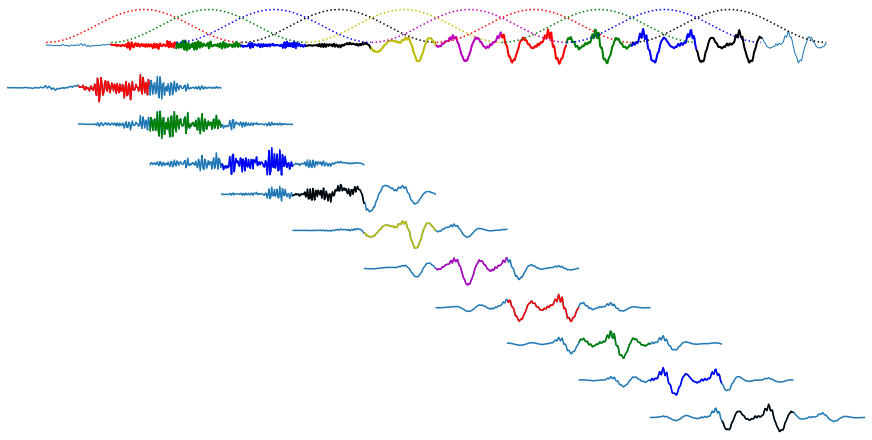

In [6]:
plt.close()
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
 
i1=65
n=10
wavshow = wavdata[(i1-1)*n_shift:]
nx = (n_length-n_shift)//2
wav_as_frames = Sps.make_frames(wavdata,pad=nx,n_shift=n_shift,n_length=n_length,preemp=0.0,window='hamming')
window = librosa.filters.get_window('hamming',n_length)

colors = ['r','g','b','k','y','m']
fig = Spd.SpchFig(row_heights=([2]+n*[1]),dpi=72)
ax=fig.axes;

#ax[0].plot(wavdata[(i1-1)*n_shift:(i1+n+1)*n_shift])
ax[0].plot(wavshow[:(n+2)*n_shift],linewidth=1)
ax[0].axis('off')
plt.close()
ix1 = np.arange(1,n+1)*n_shift
ix2 = ix1+n_shift
for i in range(n):
    xx1 = np.arange(ix1[i],ix2[i])
    xx2 = np.arange(ix1[i]-nx,ix2[i]+nx)
    ax[0].plot(xx1,wavshow[ix1[i]:ix2[i]],color=colors[i%6],linewidth=2)
    ax[0].plot(xx2,window,linestyle=':',color=colors[i%6])
    ax[i+1].plot(xx2,wav_as_frames[:,i1+i])
    ax[i+1].plot(xx1,wav_as_frames[nx:nx+n_shift,i1+i],color=colors[i%6])
    ax[i+1].axis('off')
    ax[i+1].set_xlim([0,n_shift*(n+2)])
fig

### 1.2 Spectrogram

A spectrogram is a 2D (time,frequency) arrangement showing how much energy there is in a frequency at any given moment in time.
It is computed by a sliding window approach in which a Fourier spectrum is computed of each frame.
These individual spectra are then arranged in the 2D spectrogram structure.   
Remark that the phase information from the Fourier spectra is not shown, as it is considered irrelevant.

A Fourier spectrogram is a popular way of 'looking' at speech as many speech characteristics are more obvious in the time-frequency
domain than in the time domain.   
In a classical display we view a spectrogram time-aligned with the waveform.   

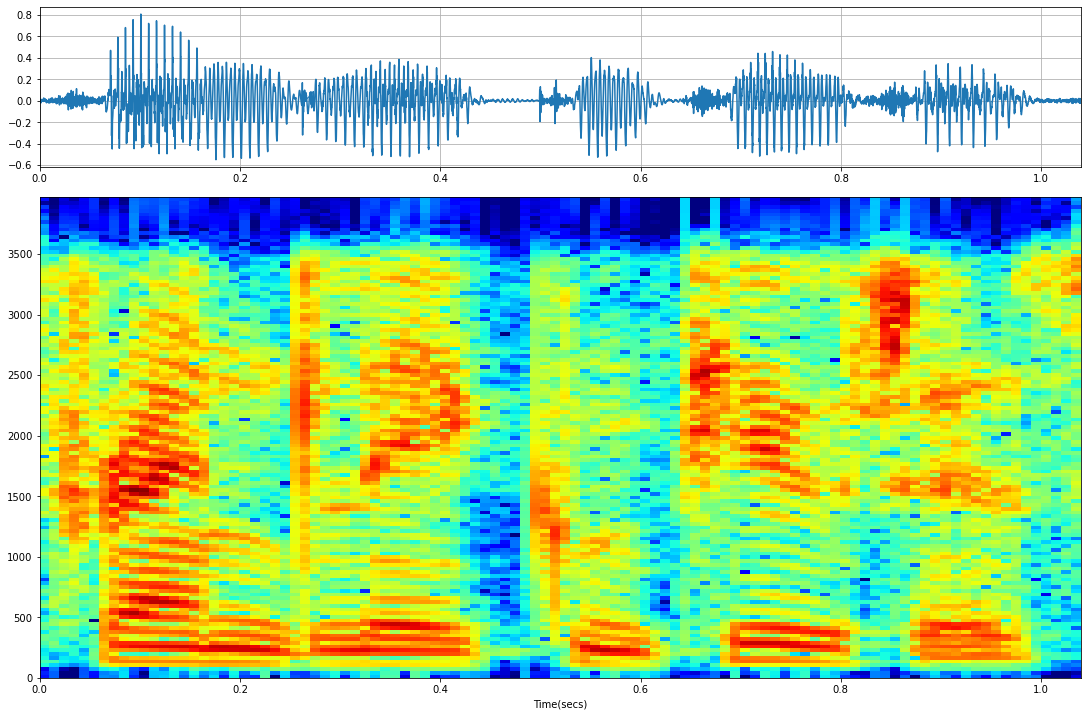

In [7]:
spgfreq = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None)
(nparam,nfr)=spgfreq.shape
d_freq = sr/(2.*(nparam-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spgfreq,sample_rate=sr,figsize=(15,10))
fig

#### Alternatice views
When you want to look in detail, a waterfall plot or a plot showing spectral slices is advised

- in a first example, we show a 2D waterfall plot next to a standard spectrogram
- in the second example we highligh individual frames in the right hand pane

In [8]:
# 
def specgram_frames(selected_frames):
    fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=selected_frames,sample_rate=sr,figsize=(10,6),dpi=100,img_ftrs=[None])

    frame_range = np.arange(selected_frames[0],selected_frames[1])
    X= spgfreq[:,frame_range]
    fig.add_waterfall2D(X,iax=2,dx=0.01,x0=selected_frames[0]*.01)
    fig.axes[2].set_ylabel("Frequency (coefficient)")
    display(fig)
#specgram_frames([50,65])
w=interactive(specgram_frames,selected_frames=widgets.IntRangeSlider(min=1,max=nfr,value=(nfr/2,nfr/2+10),description='Frames',layout=widgets.Layout(width='10in')));
w

interactive(children=(IntRangeSlider(value=(52, 62), description='Frames', layout=Layout(width='10in'), max=10…

In [9]:
# when you want to look in detail, a waterfall plot or a plot showing spectral slices is advised
def specgram_frame1(iframe):
    times=[iframe*shift,(iframe+1)*shift]
    itimes=[(iframe-1)*n_shift,(iframe+2)*n_shift]
    fig = Spd.SpchFig(col_widths=[3,1],row_heights=[1,3],figsize=(10,6),dpi=100)
    fig.add_line_plot(wavdata, iax = [0,0],dx=1/sr)
    fig.add_img_plot(spgfreq, iax=[1,0],dx=shift)
    fig.add_line_plot(wavdata[itimes[0]:itimes[1]],iax=[0,1],dx=1/sr,x0=itimes[0]/sr)
    fig.add_line_plot(spgfreq[:,iframe],iax=[1,1])
    mark_selection([fig.axes[0],fig.axes[2]],times)
    #fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=[iframe,iframe+1],sample_rate=sr,figsize=(10,6),dpi=100)
    #fig.add_waterfall2D(spgfreq,iax=2,frames=selected_frames)
    #fig.axes[2].set_ylabel("Frequency (coefficient)")
    display(fig)

w=interactive(specgram_frame1,iframe=widgets.IntSlider(min=1,max=(nfr-2),value=nfr/2,
                        description='Frame',layout=widgets.Layout(width='8in',border='1px solid')));
w

interactive(children=(IntSlider(value=52, description='Frame', layout=Layout(border='1px solid', width='8in'),…

## 1.3. Feature Extraction for Speech Recognition
The Fourier Spectrogram may only be the first step in a pipeline of spectral analysis that will yield feature vectors as input for a speech recognition   
The full feature extraction may exist of a number of steps, such as:
- Fourier Spectrogram   
- Mel Spectrogram : maps the linear frequency scale of the Fourier Spectrogram onto an auditory scale (mel)   
- MFCCs : this is a low dimensional representation of the mel spectrogram where the features are highly decorrelated and 
    hence intrinsically easier to handle by any classifier
- mean and variance normalization : may be used to have predictable ranges of values; this may be done at sentence or paragraph level
 
MFCCs where the reference features used in HMM/GMM recognizers.   
Today's DNN based recognizers typically use a high resolution Mel Spectrogram.   
In the speech recognition demos below we use MFCCs as they work best when there is little data, as is the case in the demo.

The figure below shows:
- a Fourier spectrogram
- 80 channel mel spectrogram derived by mapping the Fourier spectrum onto the mel scale (= auditory frequency scale)
- 12 MFFCs derived from the mel spectra by DCT conversion and truncation
- 12 normalized MFFCCs by mean and variance normalization





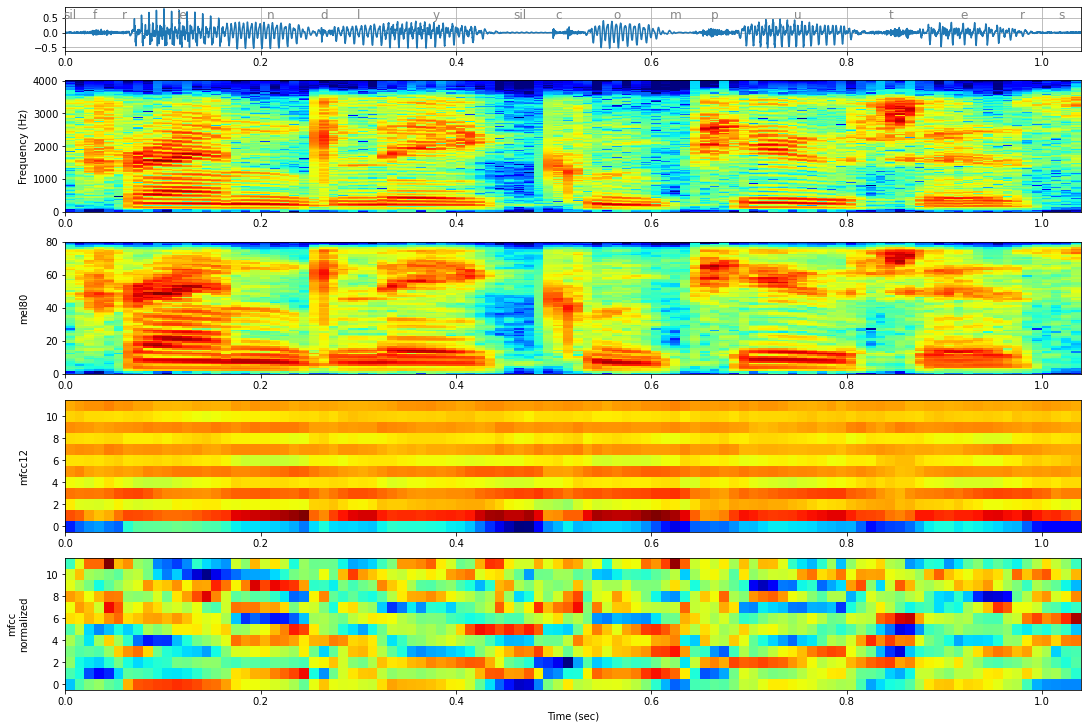

In [10]:
mel80 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=80)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=12,dct_type=3)
# mean and variance normalization
ftrs = (mfcc -mfcc.mean(axis=1,keepdims=True) )/ mfcc.std(axis=1,keepdims=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mfcc,ftrs], img_labels=['mel80','mfcc12','mfcc\nnormalized'])
fig.axes[3].set_yticks(np.arange(0,12,2)+0.5)
fig.axes[3].set_yticklabels(np.arange(0,12,2))
fig.axes[4].set_yticks(np.arange(0,12,2)+0.5)
fig.axes[4].set_yticklabels(np.arange(0,12,2))

fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
display(fig)

## 2. Speech Recognition
Traditionally speech recognition is a 2-tier process.   
1. from a single feature (or a set of adjacent features) frame probabilities are computed for the varies targets (eg phones) at that moment in time
2. from the sequence of frame probabilities the optimal sequence of phones is found subject to linguistic constraints, eg. limiting to existing words, probable sentences, minimum duration, ...   

It is obviously also possible to do recognition or classification on a frame by frame basis using the frame probabilities.
However, such process does not result in accurate nor smooth alignments.  Applying some form of linguistic constraint will greatly improve on a frame based recognition.

In the demo below we train a mini classfier to show how the intrinsic ambiguities in speech processing and how the
stochastic behavior of a speech recognizer can help us overcome this.  
When trained with full MFCCs on used on the same sentence, then frame recognition is almost perfect.  However, using only a smaller subset of features for recognition ( set nftrs_tst to a number smaller than 12 ) gives a gradually poorer recognition quality.

In [11]:
# train a mini classifier on the example data (just to get an idea of how things work !)
# first convert the available segmentations to frame labels
# We are using a simple Bayesian approach with a single Gaussian distribution per class
(fr_indx,lbls) = seg2lbls(seg,shift=0.01)
y_train = np.asarray(lbls,dtype='<U3')
clf = GaussianProcessClassifier(random_state=0).fit(ftrs[:,fr_indx].T, y_train)    
classes = clf.classes_

## 2.1 Frame and Segment Recognition

In [78]:
# for illustration purpose we focus on a limited segment of the full sentence
# and we also order the labels in the sequence that they occur
class_fig = [ classes.tolist().index(lbl) for lbl in fig_labels ]
# The example below - obtained from an artificially small system, trained on itself -
# shows perfect recognition rates at the frame level
# However, in practice recognition rates at the frame level may be around 70-80% or lower.
# You can similuate such real life behavior by adding noise to the features,
# either by limiting the number of parameters (e.g. nparam<10) or by adding noise (eg. std>.5)
# here we are creating different levels of noisy features :  ftrs1 -> easy, ftrs2 -> difficult but feasible, ftrs3 -> several mistakes
ftrs1 = noisy_features(ftrs,nparam=12,std=.1)
ftrs2 = noisy_features(ftrs,nparam=12,std=.7)
ftrs3 = noisy_features(ftrs,nparam=10,std=1.)


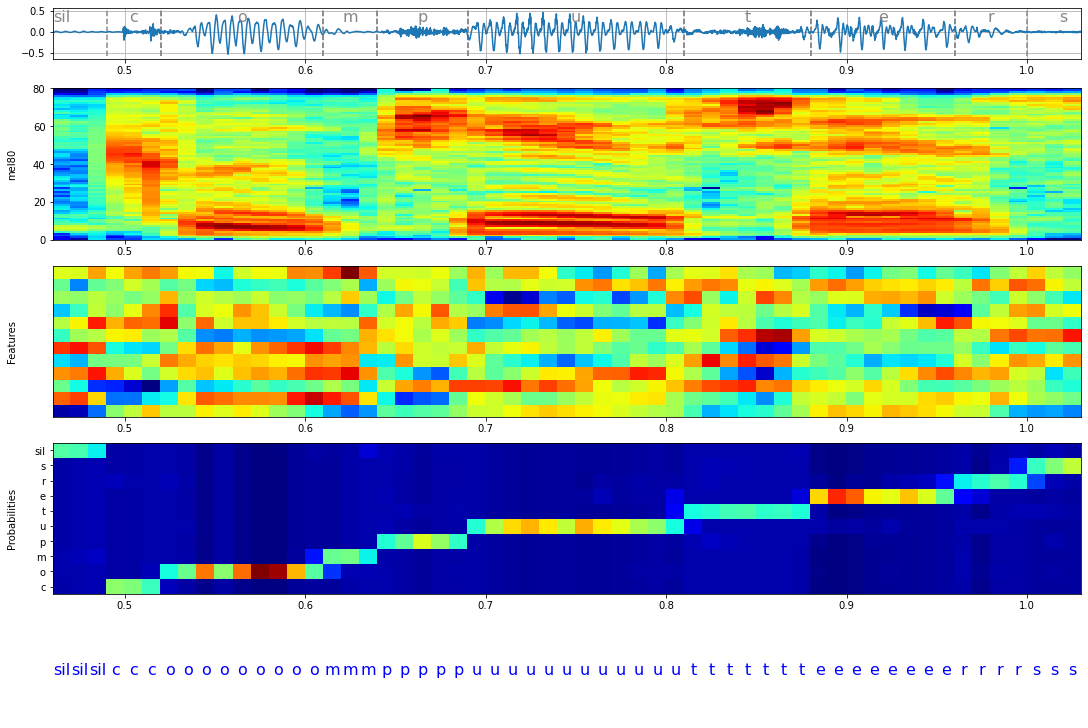

In [79]:
ftrs_tst = ftrs1
y_pred = clf.predict(ftrs_tst.T)
y_prob = clf.predict_proba(ftrs_tst.T).T
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=mel80,spglabel='mel80',dy=1,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[ftrs_tst,y_prob[class_fig,:]], 
                img_labels=['Features','Probabilities'],  
                line_ftrs=[None], line_labels=['',''])
fig.add_seg_plot(seg,iax=0,ypos=.85,color='#888',Lines=True)
fig.axes[2].set_yticks([])
fig.axes[3].set_yticks(np.arange(len(class_fig))+0.5)
fig.axes[3].set_yticklabels(classes[class_fig])
fig.add_seg_plot(lbls2df(y_pred,style="lbl"),iax=4,ypos=.5,color='#00F')
fig.axes[4].axis('off')
display(fig)

The figure below highlights that:
- the current frame probabilities are computed from the current internal representation (embedding)
- this representation is learned from a spectral segment (5 to 20 frames wide)
- each frame in a segment is computed from a window of sampled data, which is wider than the frame shift; hence the current frame probability may be derived from a segment of sampled data of 70-200msec wide.

By using a sliding window approach, ultimately the frame probabilities (and optionally recognition)
are obtained for the full utterance.

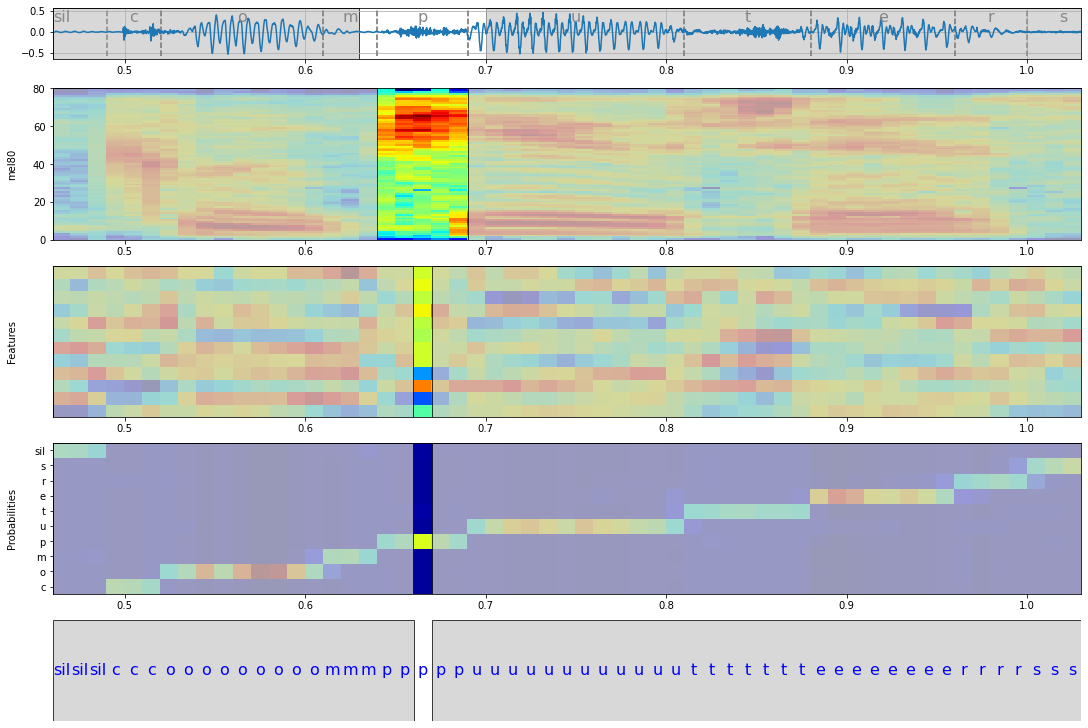

In [80]:
high_light(fig,time=.66,nx=[3,2,0,0,0])
fig

## 2.2  Sequence Recognition -- making sense of (imperfect) label sequences

The final step is to make sense of these sequence of estimated frame labels. They will contain plenty of errors and as such there is no way to trivially convert them to letters or words.  Instead of relying on the frame recognition, we go back to the frame probabilities
and find the most "sense making" output given that probabilistic input.
A major underlying technique to achieve this is called "dynamic programming".
A plethora of related techniques are used in speech recognition with names such as **Dynamic Time Warping**, **Hidden Markov Models**, **Recurrent Neural Nets**, ...   
In this demo we use a simple HMM with almost uniform transition probabilities but with a small boost of self-loop probabilities (as phonemes last longer than 1 frame) and likely phoneme transitions (as seen in a limited dictionary)

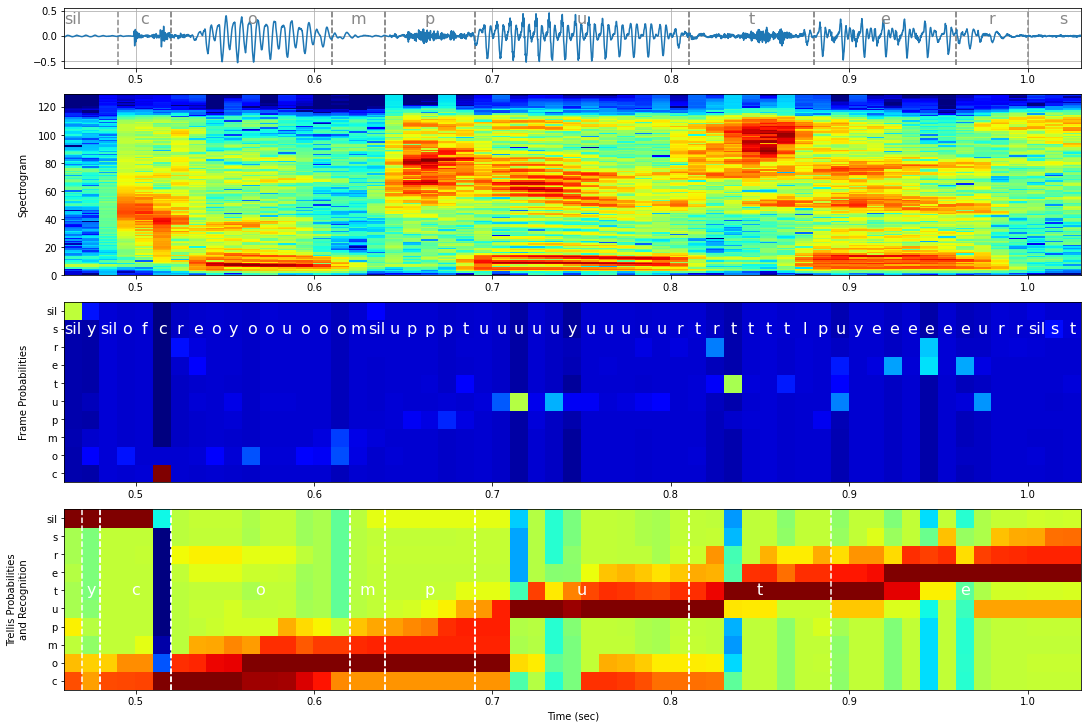

In [81]:
ftrs_tst = ftrs3
y_pred = clf.predict(ftrs_tst.T)
y_prob = clf.predict_proba(ftrs_tst.T).T
trellis_floor = .5
hmm = libhmm.DirectHMM(n_states=len(classes),prob_style="prob",states=classes)
hmm.init_topology(type="ergodic",selfprob=1.07*(1./hmm.n_states))

idx = [classes.tolist().index(s) for s in bigrams]
for ix in range(0,len(bigrams)-1):
    i=idx[ix]
    j=idx[ix+1]
    hmm.transmat[i,j]=1.05*hmm.transmat[i,j]
frameprobs, trellis, backptrs, backtrace,scale = hmm.viterbi_trellis(y_prob[:,:].T,col_norm=True)
#
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,spglabel='Spectrogram',dy=1,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[frameprobs.T[class_fig,:],np.maximum(trellis.T[class_fig,:],trellis_floor)], 
                img_labels=['Frame Probabilities','Trellis Probabilities\nand Recognition'])
fig.add_seg_plot(seg,iax=0,ypos=.85,color='#888',Lines=True)

fig.axes[2].set_yticks(np.arange(len(class_fig))+0.5)
fig.axes[2].set_yticklabels(classes[class_fig])
fig.axes[3].set_yticks(np.arange(len(class_fig))+0.5)
fig.axes[3].set_yticklabels(classes[class_fig])


fig.add_seg_plot(lbls2df(y_pred,style='lbl'),iax=2,ypos=.85,color='#FFF')
fig.add_seg_plot(lbls2df(classes[backtrace]),iax=3,ypos=.55,color='#FFF')
#fig.axes[4].set_ylabel('Recognition')
display(fig)

In practice the frame based recognition is far from perfect and speech recognition needs to rely heavily 
on dynamic programming and linguistic information to get a proper output 

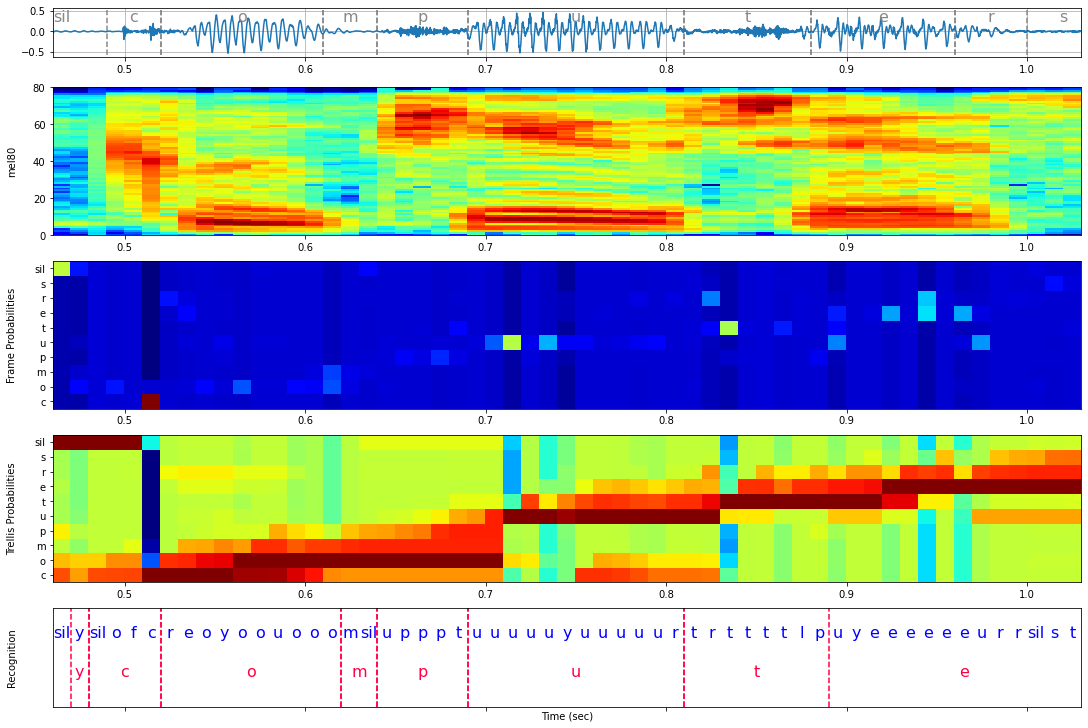

In [82]:
trellis_floor = .3
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=mel80,spglabel='mel80',dy=1,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[frameprobs.T[class_fig,:],np.maximum(trellis.T[class_fig,:],trellis_floor)], 
                img_labels=['Frame Probabilities','Trellis Probabilities'],
                line_ftrs=[None], line_labels=[''])
fig.add_seg_plot(seg,iax=0,ypos=.85,color='#888',Lines=True)

fig.axes[2].set_yticks(np.arange(len(class_fig))+0.5)
fig.axes[2].set_yticklabels(classes[class_fig])
fig.axes[3].set_yticks(np.arange(len(class_fig))+0.5)
fig.axes[3].set_yticklabels(classes[class_fig])


fig.add_seg_plot(lbls2df(y_pred,style='lbl'),iax=4,ypos=.75,color='#00F')
fig.add_seg_plot(lbls2df(classes[backtrace]),iax=4,ypos=.35,color='#F04')
fig.axes[4].set_ylabel('Recognition')
display(fig)

In [83]:
ftrs_tst = noisy_features(ftrs,nparam=12,std=.2)
y_pred = clf.predict(ftrs_tst.T)
y_prob = clf.predict_proba(ftrs_tst.T).T